In [ ]:
!pip install Augmentor
!pip install handwritting-generator
!pip install wandb -qqq
!git clone https://github.com/constantin50/ocr-transformer.git
!gcloud auth login

In [ ]:
import sys
import os
import wandb
sys.path.append('/content/ocr-transformer')
from config import *
from dataset import *
from model import *
from train import *
from utilities import *
from pretrain import *
import handwritting_generator
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### CREATE MIXED DATASET: PRETRAIN DATASET + TRAIN DATASET

In [ ]:
!mkdir /content/pretrain_set
g = handwritting_generator.Generator()
g.upload_source('/content/ocr-transformer/pretrain_data/source.txt')
batch = g.generate_batch(batch_size=5000)
i = 0
f = open('/content/labels.tsv','w',encoding='utf-8')
for b in batch:
    b[0].save('/content/pretrain_set/img'+str(i)+'.png')
    f.write('img'+str(i)+'.png'+'\t'+b[1]+'\n')
    i += 1
    

mkdir: cannot create directory ‘/content/pretrain_set’: File exists
48098 expressions have been udploaded


In [ ]:
!gsutil cp gs://handwritten_rus/real_cyr_dataset.zip /content/
!unzip /content/real_cyr_dataset.zip -d /content/real_cyr_dataset

In [ ]:
img2label=get_mixed_data('/content/pretrain_set/','/content/labels.tsv','/content/real_cyr_dataset/real_cyr/','/content/real_cyr_dataset/labels.tsv',pretrain_part=0.3)
chars = hp.cyrillic
print('Characters:', len(chars), ':', ' '.join(chars))


char2idx = {char: idx for idx, char in enumerate(chars)}
idx2char = {idx: char for idx, char in enumerate(chars)}

X_val, y_val, X_train, y_train = train_valid_split(img2label,val_part=0.1)

X_train = generate_data(X_train, '/content/pretrain_set/')
X_val = generate_data(X_val, '/content/pretrain_set/')

train_dataset = TextLoader(X_train, y_train, char2idx ,idx2char, eval=False)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=hp.batch_size, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

val_dataset = TextLoader(X_val, y_val, char2idx,idx2char, eval=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False,
                                         batch_size=1, pin_memory=False,
                                         drop_last=False, collate_fn=TextCollate())

train_dataset.get_info()

  1%|          | 147/18580 [00:00<00:12, 1462.22it/s]

ValueError: ['']
Characters: 92 : PAD SOS   ! " % ( ) , - . / 0 1 2 3 4 5 6 7 8 9 : ; ? [ ] « » А Б В Г Д Е Ж З И Й К Л М Н О П Р С Т У Ф Х Ц Ч Ш Щ Э Ю Я а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я ё EOS
valid part:2064
train part:18580


100%|██████████| 2064/2064 [00:01<00:00, 1922.49it/s]

Size of dataset: 18580
Max length of expression: 31
The most common char: ('о', 12850)
 The least common char: ('=', 1)


In [ ]:
!gsutil cp gs://handwritten_rus/benchmark.zip /content/
!unzip /content/benchmark.zip -d /content/benchmark1

них
объяснить
Архитекторы
кроме
Докажем
либеральной
экономическое
полученные
получаем


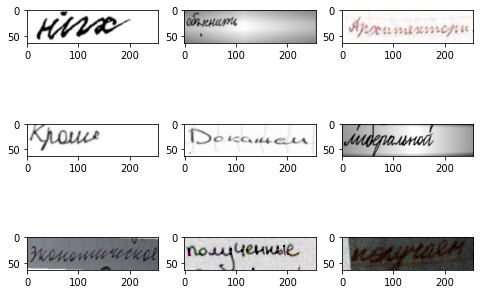

In [ ]:
# CHECK SOME EXAMPLES
expls = train_dataset.random_exp(n=9,show=True)

In [ ]:
# CREATE A MODEL
model = TransformerModel('resnet50', len(chars), hidden=512, enc_layers=2, dec_layers=2,   
                         nhead=hp.nhead, dropout=0.2, pretrained=True).to(device)

path.chk = r'/content/drive/MyDrive/log/resnet50_trans_last.pt'
#INITILIZE A STATE
model ,epochs, best_eval_loss_cer, valid_loss_all, train_loss_all, eval_accuracy_all, eval_loss_cer_all = load_from_checkpoint(model,path.chk)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



backbone: resnet50
layers: 2
heads: 4
dropout: 0.2
38,841,758 trainable parameters
weights have been loaded


In [ ]:
valid_loss_all, train_loss_all, eval_accuracy_all, eval_loss_cer_all = [], [], [], []
epochs, best_eval_loss_cer = 0, float('inf')

# CREATE A DIRECTORY WITH LOGS
os.makedirs(path.log, exist_ok=True)

In [ ]:
# TRAIN
optimizer = optim.AdamW(model.parameters(), lr=hp.lr)
criterion = nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
wandb.init(project="transformer_ocr", config={
    "learning_rate":hp.lr,
    "padding_color":'white',
    "Affine trans": 'True',
    "dropout": hp.dropout,
    "batch_size": 32,
    "architecture": "RESNE50 + TRANSFORMER",
    "dataset": "64x512 train 17k",
    "classes": "92",
    "layers" : "2"
})
config = wandb.config

hp.log = r"/content/drive/MyDrive/log/"
train_all(model,optimizer,criterion,scheduler,epochs,\
          best_eval_loss_cer,train_loader,\
          val_loader,valid_loss_all,train_loss_all,eval_loss_cer_all,\
          eval_accuracy_all,logging=True)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch: 01
-----------train------------
[ 500 / 2322 ]
[ 1000 / 2322 ]
[ 1500 / 2322 ]
[ 2000 / 2322 ]


  1%|          | 11/2064 [00:00<00:19, 103.42it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.35it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьу
0.11764705882352941
Real: (вспомнить
Pred: (вспомить
0.1
Real: Даже работа
Pred: Дажеработа
0.09090909090909091
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: рек,
Pred: рек.
0.25
Real: Пальмира
Pred: Пальтира
0.125
Real: сидок
Pred: Сидок
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетые
0.1111111111111111
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: процессов).
Pred: процесов)
0.18181818181818182
Real: багинями
Pred: бахинями.
0.2222222222222222
Real: этого региона
Pred: этого ретона
0.15384615384615385
Real: семитов
Pred: семитов.
0.125
Real: город Эбала
Pred: город эбола
0.18181818181818182
Real: (совр. Тель-
Pred: (совр. Тель
0.08333333333333333
Real: открытие
Pred: открыние
0.125
Real: Большие
Pred: Больше
0.14

  1%|          | 11/2064 [00:00<00:20, 100.31it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.14it/s]


-----------eval------------
Real: конусах.
Pred: конусаж.
0.125
Real: продолжила борьбу
Pred: продолискла бороду
0.2777777777777778
Real: (вспомнить
Pred: (вспомить
0.1
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Малая
Pred: малая
0.2
Real: прилегающие
Pred: прилеганацие
0.25
Real: рек,
Pred: рек.
0.25
Real: Библ
Pred: Биби
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: Сидон
0.4
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: география
Pred: леография
0.1111111111111111
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахинями.
0.2222222222222222
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: семитов
Pred: семитов.
0.125
Real: город Эбала
Pred: город эбала
0.09090909090909091
Real: т.к.
Pred: п.к.
0.25
Real: Большие
Pred: Б

  1%|          | 11/2064 [00:00<00:19, 104.68it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:19<00:00, 103.60it/s]


-----------eval------------
Real: конусах.
Pred: конусаж.
0.125
Real: продолжила борьбу
Pred: продолжикла борьду
0.1111111111111111
Real: (вспомнить
Pred: (вспомить
0.1
Real: Даже работа
Pred: Дажеработа
0.09090909090909091
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Малая
Pred: малая
0.2
Real: Азия
Pred: Азил
0.25
Real: прилегающие
Pred: прилеганации
0.3333333333333333
Real: рек,
Pred: рек.
0.25
Real: Библ
Pred: Бибел
0.2
Real: Пальмира
Pred: Пальшира
0.125
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетское
0.36363636363636365
Real: Иордан,
Pred: Йордан,
0.14285714285714285
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бажинями.
0.2222222222222222
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город 3бала
0.09090909090909091
Real: открытие


  0%|          | 10/2064 [00:00<00:21, 96.61it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.70it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: Азия
Pred: Азил
0.25
Real: прилегающие
Pred: прилеганция
0.2727272727272727
Real: рек,
Pred: рек.
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: Сидок
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: география
Pred: исграфия
0.3333333333333333
Real: побережые
Pred: побережое
0.1111111111111111
Real: и
Pred: и.
0.5
Real: Иордан,
Pred: Йордан,
0.14285714285714285
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахинями.
0.2222222222222222
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город зобыла
0.25
Real: 31
Pred: зя
1.0
Real: открытие
Pred: Открытие
0.125
Real: Большие
Pred: Бо

  1%|          | 11/2064 [00:00<00:20, 101.43it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.27it/s]


-----------eval------------
Real: (вспомнить
Pred: (вспомить
0.1
Real: созда-
Pred: создь-
0.16666666666666666
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: Сидок
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: посережое
0.2222222222222222
Real: река
Pred: речка
0.2
Real: Иордан,
Pred: Кордан
0.2857142857142857
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекаль в
0.08333333333333333
Real: этот регион
Pred: этот регон
0.09090909090909091
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город эбола
0.18181818181818182
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: Мари. Пранзит
0.23076923076923078
Real: Эбла
Pred: Юбла
0.25
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: 

  1%|          | 11/2064 [00:00<00:20, 101.07it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.60it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжиклаборьбу
0.11764705882352941
Real: (вспомнить
Pred: (вспомить
0.1
Real: созда-
Pred: созда
0.16666666666666666
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объезди
0.2857142857142857
Real: прилегающие
Pred: прилеганации
0.3333333333333333
Real: рек,
Pred: рек.
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: Сидок
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: посережье
0.2222222222222222
Real: река
Pred: реча
0.25
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахинями.
0.2222222222222222
Real: этого региона
Pred: этого ремона
0.15384615384615385
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: 31
Pred: 312
0.3333333333333333
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: партнёров
Pred: парт

  0%|          | 10/2064 [00:00<00:20, 98.18it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:19<00:00, 104.01it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борыбу
0.1111111111111111
Real: (вспомнить
Pred: (вспомить
0.1
Real: созда-
Pred: созда.
0.16666666666666666
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объезды
0.42857142857142855
Real: прилегающие
Pred: прилегающи
0.09090909090909091
Real: рек,
Pred: рек.
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: Сидок
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: география
Pred: исография
0.2222222222222222
Real: побережые
Pred: поберетые
0.1111111111111111
Real: Иордан,
Pred: Иордан.
0.14285714285714285
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого ретона
0.15384615384615385
Real: семитов
Pred: семитов.
0.125
Real: город Эбала
Pred: город збала
0.09090909090909091
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 7000
0.2
Real

  0%|          | 10/2064 [00:00<00:20, 98.86it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.10it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикила борьбу
0.10526315789473684
Real: (вспомнить
Pred: (вспомить
0.1
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Азия
Pred: Азил
0.25
Real: прилегающие
Pred: прилеганации
0.3333333333333333
Real: территории
Pred: територии
0.1
Real: рек,
Pred: рек.
0.25
Real: Библ
Pred: Библь
0.2
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: Сидои
0.4
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: география
Pred: исграфия
0.3333333333333333
Real: побережые
Pred: поберетые
0.1111111111111111
Real: Египет
Pred: Египер
0.16666666666666666
Real: река
Pred: речка
0.2
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекаль в
0.08333333333333333
Real: багинями
Pred: бахинями
0.125
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: Бо

  0%|          | 10/2064 [00:00<00:21, 95.27it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:19<00:00, 103.49it/s]


-----------eval------------
Real: конусах.
Pred: конубах.
0.125
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (всполить
0.2
Real: созда-
Pred: созда
0.16666666666666666
Real: людей).
Pred: людей
0.2857142857142857
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Малая
Pred: малая
0.2
Real: нет
Pred: неть
0.25
Real: рек,
Pred: рек.
0.25
Real: Библ
Pred: Библь
0.2
Real: Пальмира
Pred: Пальшира
0.125
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: побережные
0.1
Real: Иордан,
Pred: Иордан
0.14285714285714285
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: этот регион
Pred: этот регон
0.09090909090909091
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город 3бала
0.09090909090909091
Real: открытие
Pred: открыние
0.125
Real: в 75

  1%|          | 11/2064 [00:00<00:19, 102.65it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:19<00:00, 103.39it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продоликла борьбу
0.11764705882352941
Real: (вспомнить
Pred: (вспомить
0.1
Real: созда-
Pred: создь
0.3333333333333333
Real: Даже работа
Pred: Дажеработа
0.09090909090909091
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объезды
0.42857142857142855
Real: прилегающие
Pred: прилегация
0.2727272727272727
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидон
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: география
Pred: есография
0.2222222222222222
Real: побережые
Pred: побережье
0.1111111111111111
Real: Иордан,
Pred: Иордан
0.14285714285714285
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: этот регион
Pred: этот регон
0.09090909090909091
Real: багинями
Pred: бахинями
0.125
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: семитов
Pred: семитов.
0.125
Real: город Эбала
Pred: город эбла
0.181818

  1%|          | 11/2064 [00:00<00:19, 105.65it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.85it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: созда-
Pred: создь
0.3333333333333333
Real: Даже работа
Pred: Фажеработа
0.18181818181818182
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальтира
0.125
Real: сидок
Pred: Сидон
0.4
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: побережое
0.1111111111111111
Real: река
Pred: речка
0.2
Real: Мертвое море.
Pred: Тёртвое море
0.23076923076923078
Real: Привлекали в
Pred: Привлекаль в
0.08333333333333333
Real: багинями
Pred: бахинями.
0.2222222222222222
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: семитов
Pred: семетов
0.14285714285714285
Real: город Эбала
Pred: город эбла
0.18181818181818182
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 7700
0.4
Real: мари.Транзит
Pred: Мари. Пранзит
0

  0%|          | 9/2064 [00:00<00:23, 86.21it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.02it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: созда-
Pred: создь-
0.16666666666666666
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Малая
Pred: малая
0.2
Real: Азия
Pred: Азил
0.25
Real: прилегающие
Pred: прилегающи
0.09090909090909091
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидон
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: явлений
Pred: Явлений
0.14285714285714285
Real: побережые
Pred: побереты
0.2222222222222222
Real: Иордан,
Pred: Иордан
0.14285714285714285
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекаль в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого ремона
0.15384615384615385
Real: семитов
Pred: семитов.
0.125
Real: город Эбала
Pred: город эбала
0.09090909090909091
Real: открытие
Pred: Открытие

  1%|          | 11/2064 [00:00<00:19, 104.39it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:19<00:00, 103.31it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: людей).
Pred: людей!
0.2857142857142857
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: Сидои
0.4
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: побережье
0.1111111111111111
Real: Иордан,
Pred: Иордан
0.14285714285714285
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахинями.
0.2222222222222222
Real: этого региона
Pred: этого речиона
0.07692307692307693
Real: город Эбала
Pred: город збала
0.09090909090909091
Real: 31
Pred: 32
0.5
Real: в 75 км
Pred: в 75 кли
0.25
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Пранзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real

  0%|          | 10/2064 [00:00<00:20, 98.47it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:19<00:00, 103.60it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолженила борой
0.2777777777777778
Real: (вспомнить
Pred: (вспомить
0.1
Real: созда-
Pred: созда
0.16666666666666666
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Мифы
Pred: Мифи
0.25
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек.
0.25
Real: Пальмира
Pred: Тальшира
0.25
Real: сидок
Pred: сидон
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетье
0.2222222222222222
Real: Иордан,
Pred: Иордан
0.14285714285714285
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекаль в
0.08333333333333333
Real: этот регион
Pred: этот регон
0.09090909090909091
Real: процессов).
Pred: процессов)
0.09090909090909091
Real: багинями
Pred: бахшнями
0.25
Real: Возможно,
Pred: Бозможно,
0.1111111111111111
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город зо

  1%|          | 11/2064 [00:00<00:19, 103.09it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.61it/s]


-----------eval------------
Real: (вспомнить
Pred: (вспомить
0.1
Real: созда-
Pred: создь
0.3333333333333333
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: Мифы
Pred: Миды
0.25
Real: Азия
Pred: Азил
0.25
Real: прилегающие
Pred: прилегающи
0.09090909090909091
Real: рек,
Pred: рек
0.25
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетье
0.2222222222222222
Real: и
Pred: и.
0.5
Real: Иордан,
Pred: Иордан
0.14285714285714285
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекаль в
0.08333333333333333
Real: этот регион
Pred: этот регон
0.09090909090909091
Real: багинями
Pred: бажинями.
0.2222222222222222
Real: этого региона
Pred: этого ремона
0.15384615384615385
Real: город Эбала
Pred: город збла
0.18181818181818182
Real: (совр. Тель-
Pred: (совр. Тель
0.08333333333333333
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: РУОО
1.0
Real: мари.Транзит
Pred: мари. Пранзит
0.1

  1%|          | 11/2064 [00:00<00:19, 106.48it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:19<00:00, 103.65it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжкла 50рьцу
0.23529411764705882
Real: (вспомнить
Pred: (вспомить
0.1
Real: Даже работа
Pred: Дажеработа
0.09090909090909091
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Мифы
Pred: Миды
0.25
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: Сидок
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: побережье
0.1111111111111111
Real: Египет
Pred: Египен
0.16666666666666666
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: этот регион
Pred: этот регон
0.09090909090909091
Real: багинями
Pred: бахинями.
0.2222222222222222
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город зобла
0.2727272727272727
Real: (совр. Тель-
Pred: (совр)Тель
0.25
Real: открытие
Pre

  1%|          | 11/2064 [00:00<00:19, 107.25it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 103.08it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продоликла борьборь
0.2631578947368421
Real: (вспомнить
Pred: (вспотить
0.2
Real: созда-
Pred: создь
0.3333333333333333
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек.
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Иордан,
Pred: Кордан,
0.14285714285714285
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: семитов
Pred: семитов.
0.125
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 7000
0.2
Real: мари.Транзит
Pred: Мари. Транзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Сарг

  0%|          | 10/2064 [00:00<00:21, 95.65it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:19<00:00, 103.54it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продоликла борьбу
0.11764705882352941
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Египет
Pred: Египен
0.16666666666666666
Real: Иордан,
Pred: Нордан
0.2857142857142857
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: Мари. Транзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона)
0.1111111111111111
Real: вы
Pred: вы-
0.3333333333333333
Re

  1%|          | 11/2064 [00:00<00:20, 102.14it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.86it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьцу
0.1111111111111111
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетье
0.2222222222222222
Real: Египет
Pred: Египен
0.16666666666666666
Real: Иордан,
Pred: Кордан,
0.14285714285714285
Real: Мертвое море.
Pred: Тертвое море
0.15384615384615385
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город зобла
0.2727272727272727
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: В000
0.4
Real: мари.Транзит
Pred: Мари. Пранзит
0.23076923076923078
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1

  0%|          | 10/2064 [00:00<00:20, 99.61it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 102.08it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Иордан,
Pred: Йордан,
0.14285714285714285
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: семитов
Pred: семитов.
0.125
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: Мари. Пранзит
0.23076923076923078
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: вы-
0

  1%|          | 11/2064 [00:00<00:19, 106.25it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 100.95it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьцу
0.1111111111111111
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Азия
Pred: Азил
0.25
Real: прилегающие
Pred: прилегающи
0.09090909090909091
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город збала
0.09090909090909091
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 7000
0.2
Real: мари.Транзит
Pred: мари. Транзит
0.07692307692307693
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: вы-
0.3

  1%|          | 11/2064 [00:00<00:19, 103.17it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 101.71it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: Мари. Транзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: вы-
0.33333333

  0%|          | 10/2064 [00:00<00:22, 92.37it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 100.86it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город збала
0.09090909090909091
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Транзит
0.07692307692307693
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона)
0.1111111111111111
Real: вы
Pred: все
0.6666666666666666
Real: вах.
Pred: в

  1%|          | 11/2064 [00:00<00:19, 103.88it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 101.31it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: людей).
Pred: людей.
0.14285714285714285
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город збала
0.09090909090909091
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Пранзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы

  1%|          | 11/2064 [00:00<00:19, 105.65it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 100.60it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: людей).
Pred: людей
0.2857142857142857
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город збала
0.09090909090909091
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Пранзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона)
0.1111111111111111
Real: вы
P

  0%|          | 9/2064 [00:00<00:23, 87.14it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 99.52it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: побережое
0.1111111111111111
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город збала
0.09090909090909091
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Транзит
0.07692307692307693
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона)
0.1111111111111111
Real: вы
Pred: вы-
0.3333333333333333
Real: богом Элом
Pred: богом Элом.
0.09090909090909091

  1%|          | 11/2064 [00:00<00:19, 103.47it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 100.95it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетье
0.2222222222222222
Real: Иордан,
Pred: Йордан,
0.14285714285714285
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город збала
0.09090909090909091
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Транзит
0.07692307692307693
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: вы-
0.3333333333333

  1%|          | 11/2064 [00:00<00:19, 102.77it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 99.48it/s] 


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город зобла
0.2727272727272727
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Пранзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: вы-
0.3333333333333333
Real: вах.
Pred: в

  0%|          | 10/2064 [00:00<00:20, 98.53it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 100.03it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город зобла
0.2727272727272727
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Транзит
0.07692307692307693
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: все
0.6666666666666666
Real: интересные
Pred: кнтересные
0.1
Real: вах.
Pred: ваз
0.5
Real: взаи

  0%|          | 10/2064 [00:00<00:20, 99.45it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 100.25it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Транзит
0.07692307692307693
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: все-
0.75
Real: вах.
Pred: ваз
0.5
Rea

  1%|          | 11/2064 [00:00<00:19, 103.50it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 99.90it/s] 


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеды
0.2857142857142857
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетые
0.1111111111111111
Real: Иордан,
Pred: Иордан
0.14285714285714285
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: в 75 км
Pred: в 75 кг.
0.25
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Транзит
0.07692307692307693
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: вы-
0.33

  1%|          | 11/2064 [00:00<00:20, 101.15it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 98.83it/s]


-----------eval------------
Real: продолжила борьбу
Pred: продолжикла борьбу
0.05555555555555555
Real: (вспомнить
Pred: (вспомить
0.1
Real: людей).
Pred: людей
0.2857142857142857
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Иордан,
Pred: Йордан,
0.14285714285714285
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого решона
0.15384615384615385
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Транзит
0.07692307692307693
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: 

  0%|          | 10/2064 [00:00<00:21, 95.42it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:20<00:00, 98.43it/s]


-----------eval------------
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: рек,
Pred: рек
0.25
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетое
0.2222222222222222
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: 31
Pred: 32
0.5
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Пранзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: все
0.6666666666666666
Real: вах.
Pred: ваз
0.5
Real: взаимосвяз.
Pred: взаимосвяз
0.09090909090909091
Real: Амореи
Pred: Аморен
0.16666666666666666
Real: вино,
Pred: вин

  1%|          | 11/2064 [00:00<00:20, 102.40it/s]


-----------valid------------


100%|██████████| 2064/2064 [00:21<00:00, 97.95it/s]


-----------eval------------
Real: (вспомнить
Pred: (вспомить
0.1
Real: Урук
Pred: Урух
0.25
Real: объеди-
Pred: объеди
0.14285714285714285
Real: Азия
Pred: Азил
0.25
Real: рек,
Pred: рек
0.25
Real: Пальмира
Pred: Пальшира
0.125
Real: сидок
Pred: сидои
0.2
Real: Ливан) сама
Pred: Ливан сама
0.09090909090909091
Real: побережые
Pred: поберетые
0.1111111111111111
Real: Мертвое море.
Pred: Мертвое море
0.07692307692307693
Real: Привлекали в
Pred: Привлекала в
0.08333333333333333
Real: багинями
Pred: бахшнями.
0.3333333333333333
Real: этого региона
Pred: этого регона
0.07692307692307693
Real: город Эбала
Pred: город зобала
0.16666666666666666
Real: открытие
Pred: Открытие
0.125
Real: Большие
Pred: Больше
0.14285714285714285
Real: 17000
Pred: 1700
0.2
Real: мари.Транзит
Pred: мари. Пранзит
0.15384615384615385
Real: царя
Pred: царя.
0.2
Real: Саргона),
Pred: Саргона).
0.1111111111111111
Real: вы
Pred: вы-
0.3333333333333333
Real: вах.
Pred: ваз
0.5
Real: взаимосвяз.
Pred: взаимоствез.
0.166666

In [ ]:
import os

os.getcwd()

'/content/drive/MyDrive/log'

In [ ]:
(wandb.save("config.yaml", base_path=".hydra/"))

In [ ]:
%cd /content/drive/MyDrive/log

/content/drive/MyDrive/log
